<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Visualización de datos - PRA2</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos</p>
    <p style="margin: 0; text-align:right; padding-button: 100px;">Christian López Vicente</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA 2: Proyecto de visualización

## Aplicación del algoritmo de kruskal para una red de transporte sobe NYC

Tal como hemos comentado a lo largo de este proyecto de visualización, el objetivo sería presentar a la directiva del departamento de Innovación de Airbnb un proyecto de transporte para el servicio de limpieza de los apartamentos de la ciudad de Nueva York. Como es un proyecto pionero, hemos aplicado tareas de limpieza de datos para reducir la dimensionalidad del dataset y empezar solo en el área de Manhattan en los apartamentos de tipo entero.

En este documento realizaremos los siguientess pasos:

- Carga de los datos limpiados de los apartamentos de airbnb.
- Representación de los datos sobre un eje.
- Determinación del número de clusters, que coincidirá con las bases de limpieza que fijaremos en Manhattan. Para ello aplicaremos la regla del codo, con el objetivo de poder determinar mediante un gráfico simple cuál es el número óptimo de bases.
- Creación de los grupos clasificados mediante un modelo matemático Kmeans. Con esto definiremos los apartamentos asignados a una base de limpieza.
- Representación de los distintos grupos.
- Creación del grafo.
- Aplicación del algoritmo de kruskal sobre el grafo creado.
- Representación de los datos sobre ejes y sobre mapa.

## 1. Carga de los datos limpios

In [12]:
import pandas as pd

df = pd.read_csv('NewYork_2019_clean.csv')
df.head(3)

,district,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,availability_365
0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,355
1,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,129
2,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,188


## 2. Visualización de los datos

Visualizamos los datos para ver donde hay mayor concentración de peticiones y facilitar el posterior análisis de los datos. ¿Puedes localizar *Central Park*?

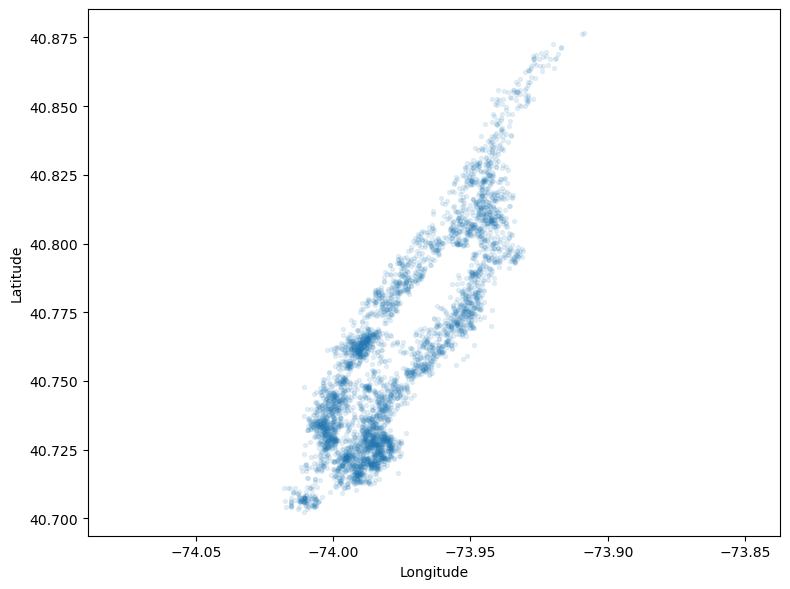

In [13]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df['longitude'], df['latitude'], s=8, alpha=.1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.tight_layout()

## 3. Determinación de las bases de limpieza: clustering

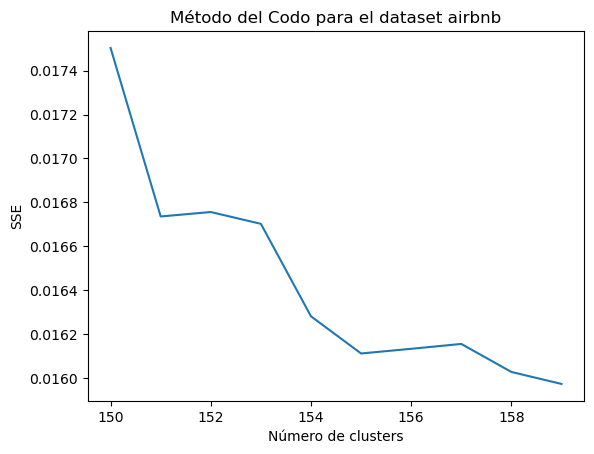

In [14]:
import numpy as np
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans

# Apliquemos la regla del codo para un total de 150 a 160 bases
abnb_data = df[['longitude','latitude']].to_numpy()
sse = []
for i in range (150,160):
    kmeans = KMeans(init="random",
                    n_clusters=i,
                    n_init=10,
                    max_iter=300,
                    random_state=42
                   )
    kmeans.fit(abnb_data)
    sse.append(kmeans.inertia_)

plt.plot(range(150, 160), sse)
plt.title('Método del Codo para el dataset airbnb')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.show()

Una vez hemos aplicado la regla del codo sobre el conjunto de datos, podemos observar que con 155 clusters obtenemos una mejora entre los 10 números que componen la lista de ejemplo que hemos usado. Creamos el modelo con ese número de clusters.

## 4. Creación del modelo de clasificación

In [15]:
# k-means aplicado al dataset de abnb_data
kmeans = KMeans(init="random",
                n_clusters=155,
                n_init=10,
                max_iter=300,
                random_state=42
               )
kmeans.fit(abnb_data)

KMeans(init='random', n_clusters=155, random_state=42)

## 5. Visualización de los grupos creados

Text(0, 0.5, 'Latitude')

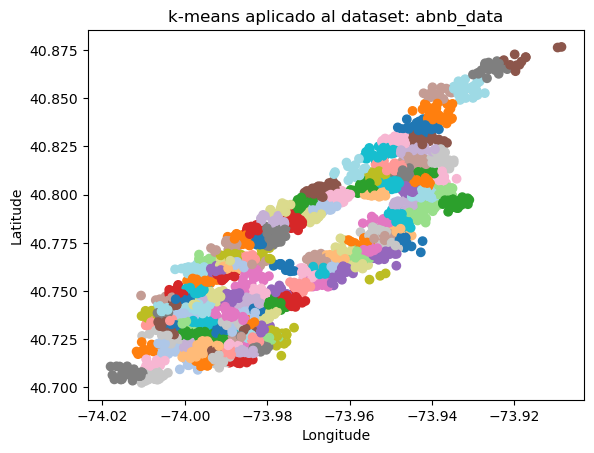

In [16]:
# Let's represent data results from the previous model
kmeans_df = pd.DataFrame(data=abnb_data,
                         columns=['longitude',
                                  'latitude']
                        )

color_vector = np.array(kmeans.labels_).ravel()
plt.scatter(kmeans_df['longitude'],
            kmeans_df['latitude'],
            cmap='tab20',
            c = color_vector)

plt.title("k-means aplicado al dataset: abnb_data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Podemos observar los distintos grupos que se han formado en el algoritmo de clusterización. Si observamos bien, se dibuja la silueta de la ciudad de Nueva York y en el centro podemos ver un hueco en blanco que corresponde con Central Park, donde es evidente que no hay alojamientos.

## 6. Diseño de la red de transporte: aplicación del algoritmo de Kruskal


Los pasos son los siguientes:
1. Preparar los datos para el grafo.
2. Aplicar el algoritmo de Kruskal.
3. Analizar los resultados y decidir el diseño final de la red.

### 6.1 Preparación de los datos

In [17]:
# Creamos un dataframe con los datos representativos de los clusters
kmeans_df['cluster'] = kmeans.labels_
kmeans_df_grouped = kmeans_df.groupby('cluster').agg({
                                                      'longitude': ['min', 'max', 'mean', 'count'], 
                                                      'latitude': ['min', 'max', 'mean']
                                                    })

# Usamos los valores medios como puntos representativos de los clusteres: ubicación de la base de limpieza
cluster_list = kmeans_df_grouped.index.tolist()
lon_mean = kmeans_df_grouped["longitude"]["mean"].tolist()
lat_mean = kmeans_df_grouped["latitude"]["mean"].tolist()
count = kmeans_df_grouped["longitude"]["count"].tolist()

df_columns = {'id': cluster_list, 'latitud': lat_mean, 'longitud': lon_mean, 'puntos': count}
df_graph = pd.DataFrame(data=df_columns)
df_graph

,id,latitud,longitud,puntos
0,0,40.729463,-73.992166,14
1,1,40.835229,-73.942452,35
2,2,40.740704,-73.981644,41
3,3,40.775750,-73.947091,24
4,4,40.731915,-74.002781,40
...,...,...,...,...
150,150,40.854468,-73.931292,32
151,151,40.740567,-74.004560,23
152,152,40.740078,-73.999388,39
153,153,40.812449,-73.959280,15


### 6.2 Creación del grafo

Siguiendo la documentación de la asignatura de Aprendizaje automático, vamos a crear el grafo, y con la clase Kruskal, aplicaremos el algoritmo que nos enlazará los distintos clusters para hacer la red de transporte más óptima posible entre las distintas bases de limpieza.

In [18]:
# Creamos el grafo para aplicar kruskal
import haversine as hs
import kruskal
from haversine import haversine
from kruskal import Graph

def create_graph_kruskal(df):
    v = len(df.index.to_list())
    # Let's start the Graph
    g = kruskal.Graph(vertex=v)
    node_list = df['id'].tolist()
    latitud_list = df['latitud'].tolist()
    longitud_list = df['longitud'].tolist()
    puntos_list = df['puntos'].tolist()
    i = 0
    while i<len(node_list)-2:
        j=i+1
        while j<len(node_list)-1: 
            id_i = node_list[i]
            id_j = node_list[j]
            pos_i = (latitud_list[i],longitud_list[i])
            pos_j = (latitud_list[j],longitud_list[j])
            weight_ij = -((puntos_list[i]+puntos_list[j])/haversine(pos_i,pos_j))
            g.add_edge(id_i, id_j, weight_ij)
            j+=1
        i+=1
    return g

graph = create_graph_kruskal(df_graph)
df_kruskal = graph.kruskal(153)
df_kruskal

,id_a,id_b,weight
0,13,136,-415.968405
1,26,28,-392.874874
2,33,83,-385.153798
3,111,147,-359.374492
4,30,64,-340.705144
...,...,...,...
148,6,13,-62.963480
149,110,150,-43.408517
150,19,150,-42.211261
151,69,128,-39.604838


Como podemos leer en este [TFG](https://biblus.us.es/bibing/proyectos/abreproy/92106/fichero/TFG-2106-MARTINEZ.pdf/): El método comienza eligiendo el arco de menor coste de un grafo no dirigido. Este proceso de elegir los arcos de menor coste se continúa hasta unir todos los nodos del gra fo sin formar lazos. O lo que es lo mismo hasta que el número de nodos sea igual al número de arcos menos uno. Finalmente, se obtiene un árbol mínimo de expansión.

Por lo tanto, dado que el número de nodos es 155, el número de arcos será de 154, por lo que el número de ejes máximos que podrá tener el algoritmo será 153. Obtenemos así el dataframe con los pesos de las aristas que unen los nodos.

### 6.3 Representación de los datos

In [19]:
# Creamos un dataframe con los datos ordenados para ser representados
df_kruskal_1 = pd.merge(df_kruskal, df_graph, left_on = "id_a", right_on = "id", how='left')
df_kruskal_2 = pd.merge(df_kruskal_1, df_graph, left_on = "id_b", right_on = "id", how='left')
df_kruskal_2.drop(['id_x', 'id_y', 'puntos_x', 'puntos_y'],inplace=True, axis=1)
df_kruskal_2

,id_a,id_b,weight,latitud_x,longitud_x,latitud_y,longitud_y
0,13,136,-415.968405,40.764444,-73.987215,40.764523,-73.989867
1,26,28,-392.874874,40.723022,-73.993448,40.721808,-73.995493
2,33,83,-385.153798,40.728123,-73.999715,40.728896,-74.002127
3,111,147,-359.374492,40.727765,-73.986281,40.727121,-73.984419
4,30,64,-340.705144,40.761885,-73.989074,40.761253,-73.992242
...,...,...,...,...,...,...,...
148,6,13,-62.963480,40.762505,-73.975806,40.764444,-73.987215
149,110,150,-43.408517,40.865207,-73.926253,40.854468,-73.931292
150,19,150,-42.211261,40.842576,-73.938894,40.854468,-73.931292
151,69,128,-39.604838,40.760996,-73.961166,40.757660,-73.952983


Aplicaremos la normalización Min-Max para definir el grosor de las líneas en la visualización del grafo.

In [20]:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_kruskal_2[['weight_scaled']] = 1-scaler.fit_transform(df_kruskal_2[['weight']])
df_kruskal_2

,id_a,id_b,weight,latitud_x,longitud_x,latitud_y,longitud_y,weight_scaled
0,13,136,-415.968405,40.764444,-73.987215,40.764523,-73.989867,1.000000
1,26,28,-392.874874,40.723022,-73.993448,40.721808,-73.995493,0.939136
2,33,83,-385.153798,40.728123,-73.999715,40.728896,-74.002127,0.918786
3,111,147,-359.374492,40.727765,-73.986281,40.727121,-73.984419,0.850843
4,30,64,-340.705144,40.761885,-73.989074,40.761253,-73.992242,0.801639
...,...,...,...,...,...,...,...,...
148,6,13,-62.963480,40.762505,-73.975806,40.764444,-73.987215,0.069635
149,110,150,-43.408517,40.865207,-73.926253,40.854468,-73.931292,0.018097
150,19,150,-42.211261,40.842576,-73.938894,40.854468,-73.931292,0.014941
151,69,128,-39.604838,40.760996,-73.961166,40.757660,-73.952983,0.008072


Text(0.5, 1.0, 'Visualización de los clusters y el grafo resultante')

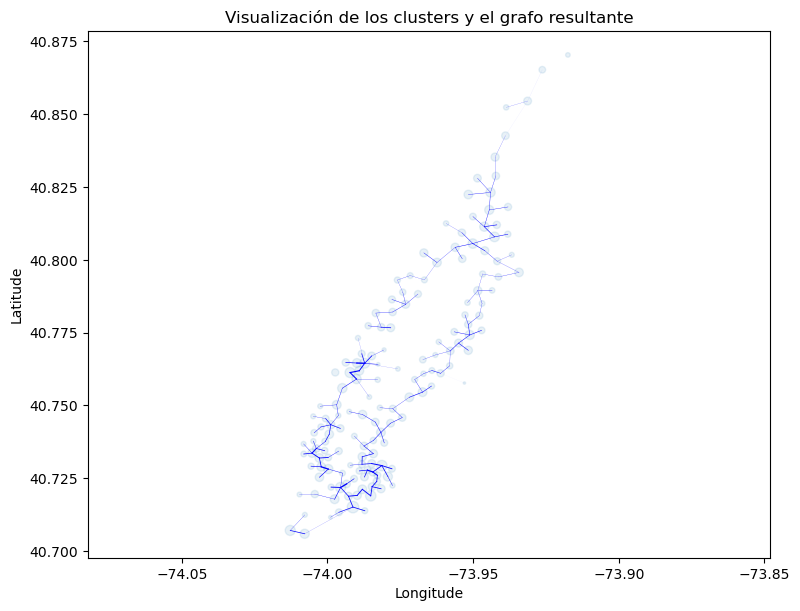

In [21]:
# Visualizamos los datos
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df_graph['longitud'], df_graph['latitud'], s=df_graph['puntos'], alpha=.1) # parameter s indicates how big
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.tight_layout()


x_points = []
y_points = []
lineswidth = df_kruskal_2["weight_scaled"].to_list()

# With the loop let's create the coordinates to join
for i in range(len(df_kruskal_2.index.to_list())):
    x_points.append([df_kruskal_2['longitud_x'][i],df_kruskal_2['longitud_y'][i]])
    y_points.append([df_kruskal_2['latitud_x'][i],df_kruskal_2['latitud_y'][i]])

# Let's draw the segment that join the clusters
for i in range(len(x_points)):
    plt.plot(x_points[i], y_points[i], color='b',linewidth=lineswidth[i])
    
plt.title("Visualización de los clusters y el grafo resultante")

### 6.4 Visualización sobre el mapa

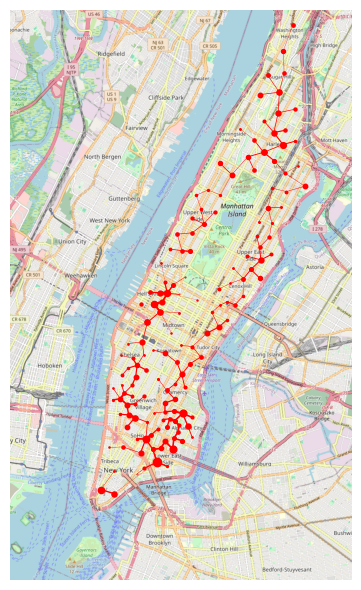

In [22]:
import smopy

# Let's adjust the coordinates to New York city
map = smopy.Map((40.718, -74.04, 40.81,-73.95), z=13)
ax = map.show_mpl(figsize=(8, 6))

# Let's scale the points number to show different sizes for the clusters on the map
df_graph['puntos_scaled'] = df_graph['puntos'].apply(lambda x: 
                                                      6*(x - min(df_graph['puntos']))
                                                     /(max(df_graph['puntos']-min(df_graph['puntos']))))

# Let's draw the points over the map
for i in range(len(df_graph.index.to_list())):
    x, y = map.to_pixels(float(df_graph['latitud'][i]),float(df_graph['longitud'][i]))
    size = df_graph['puntos_scaled'][i]
    ax.plot(x, y, 'or', markersize=size)

# With a loop let's create the coordinates to join the clusters (in pixels)
x_points = []
y_points = []
lineswidth = df_kruskal_2["weight_scaled"].to_list()
for i in range(len(df_kruskal_2.index.to_list())):
    point_1 = map.to_pixels([df_kruskal_2['latitud_x'][i],df_kruskal_2['longitud_x'][i]])
    point_2 = map.to_pixels([df_kruskal_2['latitud_y'][i],df_kruskal_2['longitud_y'][i]])
    x_points.append([point_1[0],point_2[0]])
    y_points.append([point_1[1],point_2[1]])


# Let's draw the segment that join the clusters
for i in range(len(x_points)):
    size = lineswidth[i]*2
    ax.plot(x_points[i], y_points[i],linewidth=size,c="r")